## Importing data and EDA

In [1]:
import pandas as pd
import seaborn as sns

sns.set_theme(style="dark")
sns.set_palette("pastel")

In [2]:
df = pd.read_csv("./data/text.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)
df.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [3]:
label_to_id = {
    "sadness":0,
    "joy": 1,
    "love": 2,
    "anger": 3,
    "fear": 4,
    "surprise": 5
}
n_classes = len(label_to_id)
id_to_label = {v:k for k,v in label_to_id.items()}
df["emotion"] = df["label"].map(id_to_label)

<Axes: xlabel='emotion', ylabel='count'>

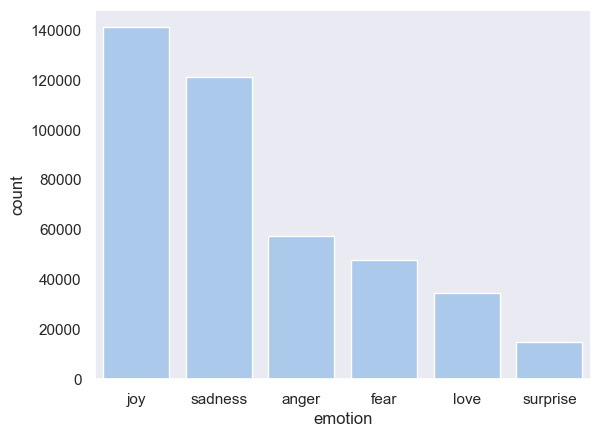

In [4]:
emotion_dist = df.emotion.value_counts().reset_index()
emotion_dist.columns = ["emotion", "count"]
sns.barplot(x="emotion", y="count", data=emotion_dist)

<Axes: xlabel='n_words', ylabel='Count'>

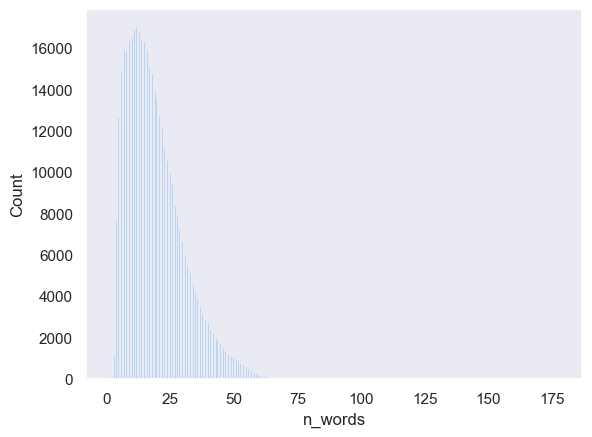

In [5]:
df["n_words"] = df["text"].str.split().str.len()
sns.histplot(df, x="n_words")

<Axes: xlabel='emotion', ylabel='cnt'>

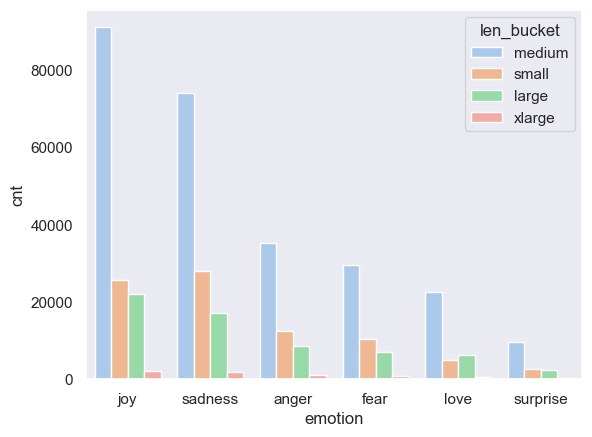

In [6]:
def len_buckets(x):
    if x < 10:
        return "small"
    elif x < 30:
        return "medium"
    elif x < 50:
        return "large"
    else:
        return "xlarge"

df["len_bucket"] = df.n_words.map(len_buckets)
x = df[["emotion", "len_bucket"]].value_counts().reset_index()
x.columns = ["emotion", "len_bucket", "cnt"]
sns.barplot(x, x="emotion", y="cnt", hue="len_bucket")

## Training a Bert based classifier

In [7]:
import torch 
from torch import nn
from torch.nn import functional as F
from transformers import AutoModel, AutoTokenizer
import tqdm 

device = "mps"

checkpoint = "prajjwal1/bert-tiny"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
bert_model = AutoModel.from_pretrained(checkpoint)

In [8]:
inputs = tokenizer(df.text[0:10].tolist(), return_tensors="pt", truncation=True, padding=True, max_length=512)
bert_model(**inputs)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-1.4217, -0.1974, -3.4200,  ...,  0.5960,  0.0088,  1.3774],
         [-1.6735,  0.1411, -0.4430,  ..., -1.3566,  0.1415,  1.0689],
         [-1.3555, -0.4540, -0.9067,  ..., -1.2008, -0.5649,  2.0236],
         ...,
         [-1.3208, -0.1553, -0.6254,  ...,  0.7651, -1.1930,  1.7198],
         [-1.2291, -0.0975, -0.5818,  ...,  0.6200, -0.5607,  2.7154],
         [-0.6381, -0.8642, -0.4012,  ...,  0.8525, -0.6343,  2.4986]],

        [[-1.5776, -0.3786, -4.5858,  ...,  0.1621, -0.2806,  1.1588],
         [-1.2961,  0.3928, -0.3564,  ..., -1.0980, -0.7440,  0.6168],
         [-1.0788, -0.5728,  0.6087,  ..., -2.9751, -0.8776,  0.6535],
         ...,
         [-0.9678,  0.5244, -0.3406,  ...,  0.6109, -1.3455,  1.0133],
         [-1.3892,  0.4409, -0.3329,  ..., -0.2299, -0.6662, -0.2661],
         [-1.7254, -0.2014,  0.3691,  ...,  0.3882, -1.3976,  0.8405]],

        [[-1.6570, -0.4850, -4.0459,  ..., -0.2572,  

### Creating Dataset and DataLoader

In [9]:
from torch.utils.data import Dataset, DataLoader

class EmotionDataset(Dataset):

    def __init__(self, df, tokenizer, max_len=512):
        self.text = df.text.tolist()
        self.labels = df.label.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = self.text[index]
        return {
            "text": text,
            "labels": self.labels[index]
        }


class EmotionCollator:
    def __init__(self, tokenizer, max_len=512, device="mps"):
        self.tokenizer = tokenizer
        self.max_len = max_len

    def collate_fn(self, batch):
        sentence_batch = [example["text"] for example in batch]
        labels_batch = [example["labels"] for example in batch]

        inputs = self.tokenizer(
            sentence_batch,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=self.max_len
        )

        labels = torch.tensor(labels_batch, dtype=torch.long)
        return {
            'input_ids': inputs['input_ids'].to(device),
            'attention_mask': inputs['attention_mask'].to(device),
            'labels': labels.to(device)
        }

In [10]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=43,
    stratify=df.emotion,
    shuffle=True
)

In [11]:
train_ds = EmotionDataset(train_df, tokenizer)
test_ds = EmotionDataset(test_df, tokenizer)
emotion_collator = EmotionCollator(tokenizer)

train_dataloader = DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True,
    collate_fn=emotion_collator.collate_fn
)
test_dataloader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=True,
    collate_fn=emotion_collator.collate_fn
)

In [12]:
for batch in test_dataloader:
    print(batch["input_ids"])
    print(batch["labels"])
    print(batch["attention_mask"])
    break

tensor([[ 101, 1045, 2514,  ...,    0,    0,    0],
        [ 101, 1045, 2514,  ...,    0,    0,    0],
        [ 101, 1045, 2293,  ...,    0,    0,    0],
        ...,
        [ 101, 1045, 2514,  ...,    0,    0,    0],
        [ 101, 1045, 2514,  ...,    0,    0,    0],
        [ 101, 1045, 2031,  ...,    0,    0,    0]], device='mps:0')
tensor([3, 3, 3, 0, 0, 3, 1, 4, 0, 0, 0, 1, 0, 5, 0, 3, 2, 0, 3, 1, 1, 4, 4, 3,
        0, 0, 3, 2, 1, 2, 3, 5], device='mps:0')
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='mps:0')


## Create classification model

In [13]:
class EmotionClassifier(nn.Module):
    def __init__(self, bert_model, num_labels, expansion_factor=2):
        super(EmotionClassifier, self).__init__()
        self.bert_model = bert_model
        H = bert_model.config.hidden_size
        self.linear1 = nn.Linear(H, H * expansion_factor)
        self.linear2 = nn.Linear(H * expansion_factor, num_labels)

    def forward(self, inputs):
        x = self.bert_model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"]).pooler_output
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

## Training loop

In [14]:
classifier_model = EmotionClassifier(bert_model, num_labels=n_classes).to(device)
optimizer = torch.optim.Adam(classifier_model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()
epochs = 5


In [16]:
len(train_dataloader), len(test_dataloader)

(10421, 2606)

In [21]:
for batch in test_dataloader:
    output = classifier_model(batch)
    print(output.shape)
    break

torch.Size([32, 6])


In [22]:
output.shape

torch.Size([32, 6])

In [23]:
def train_model(model, optimizer, criterion, batch):
    optimizer.zero_grad()
    outputs = model(batch)
    loss = criterion(outputs, batch["labels"])
    loss.backward()
    optimizer.step()
    return loss

def evaluate_model(model, criterion, batch):
    with torch.no_grad():
        outputs = model(batch)
        loss = criterion(outputs, batch["labels"])
    return loss

In [24]:
train_loss = []
val_loss = []

In [26]:
for epoch in range(epochs):
    total_loss = 0
    for train_batch_idx, batch in enumerate(train_dataloader):
        classifier_model.train()
        loss = train_model(classifier_model, optimizer, criterion, batch)
        total_loss += loss.item()

        if (train_batch_idx+1) % 10 == 0:
            train_loss.append(total_loss)
            classifier_model.eval()
            total_loss = 0
            for val_batch_idx, batch in enumerate(test_dataloader):
                loss = evaluate_model(classifier_model, criterion, batch)
                total_loss += loss.item()
                if (val_batch_idx+1) % 10 == 0:
                    break
            val_loss.append(total_loss)
            total_loss = 0
            print(f"[train] loss:{round(train_loss[-1], 3)} idx:{train_batch_idx} [val] loss:{round(val_loss[-1], 3)} idx:{val_batch_idx}")

[train] loss:10.942 idx:9 [val] loss:11.508 idx:9
[train] loss:11.663 idx:19 [val] loss:11.31 idx:9
[train] loss:11.736 idx:29 [val] loss:11.997 idx:9
[train] loss:11.329 idx:39 [val] loss:11.662 idx:9
[train] loss:11.23 idx:49 [val] loss:10.612 idx:9
[train] loss:11.747 idx:59 [val] loss:11.135 idx:9
[train] loss:11.491 idx:69 [val] loss:10.476 idx:9
[train] loss:10.903 idx:79 [val] loss:11.573 idx:9
[train] loss:11.833 idx:89 [val] loss:9.742 idx:9
[train] loss:11.578 idx:99 [val] loss:11.328 idx:9
[train] loss:11.646 idx:109 [val] loss:9.951 idx:9
[train] loss:11.297 idx:119 [val] loss:9.74 idx:9
[train] loss:11.026 idx:129 [val] loss:9.583 idx:9
[train] loss:11.091 idx:139 [val] loss:10.121 idx:9
[train] loss:10.828 idx:149 [val] loss:10.25 idx:9
[train] loss:10.252 idx:159 [val] loss:9.623 idx:9
[train] loss:10.947 idx:169 [val] loss:9.652 idx:9
[train] loss:10.273 idx:179 [val] loss:10.082 idx:9
[train] loss:10.493 idx:189 [val] loss:9.362 idx:9
[train] loss:10.734 idx:199 [val] 

KeyboardInterrupt: 

<Axes: >

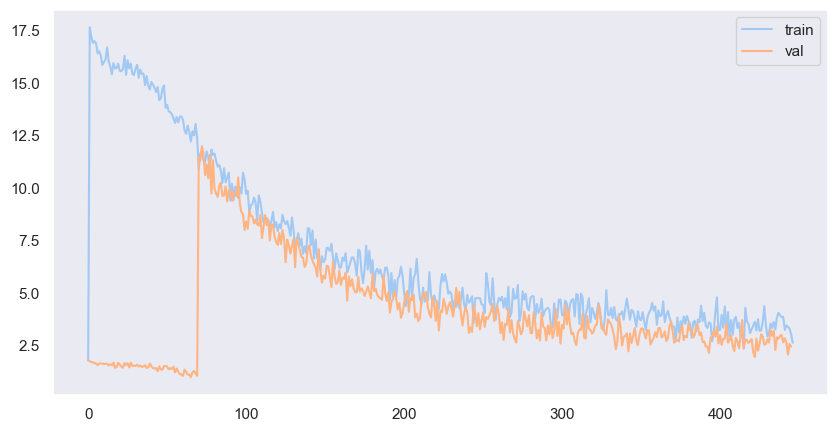

In [28]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10,5))

sns.lineplot(x=range(len(train_loss)), y=train_loss, label="train", ax=ax)
sns.lineplot(x=range(len(val_loss)), y=val_loss, label="val", ax=ax)

In [30]:
classifier_model.eval()
for batch in test_dataloader:
    with torch.no_grad():
        outputs = classifier_model(batch)
        outputs = torch.argmax(outputs, dim=1)
    break
outputs

tensor([1, 4, 1, 4, 4, 5, 1, 0, 1, 1, 3, 4, 0, 0, 4, 1, 1, 4, 1, 1, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 1, 0, 1], device='mps:0')

In [31]:
batch["labels"]

tensor([1, 4, 1, 4, 4, 5, 1, 0, 1, 1, 3, 4, 0, 1, 4, 1, 1, 4, 1, 1, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 1, 0, 2], device='mps:0')